In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')

In [26]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.sql.functions import countDistinct, col

from ast import literal_eval

Testing py files

In [3]:
# %load_ext autoreload
# %autoreload 2

# from src.recommender import *
# from src.run import *

In [5]:
requests_df = pd.read_csv('data/requests.csv')
requests_df.head()

In [7]:
# requests_df.groupby('user').count().sort_values('movie')

In [8]:
training = pd.read_csv('data/training.csv')
training.head()

In [10]:
training.groupby('user').count().sort_values('movie')

,movie,rating,timestamp
user,,,
3326,2,2,2
3038,2,2,2
4273,3,3,3
3288,3,3,3
1779,4,4,4
...,...,...,...
3618,1344,1344,1344
4277,1407,1407,1407
4169,1440,1440,1440


In [10]:
training['movie'].nunique()

3662

In [11]:
# Setup a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [12]:
# Convert a Pandas DF to a Spark DF
spark_df = spark.createDataFrame(training) 
spark_df.printSchema()

In [14]:
spark_df = spark_df.drop('timestamp')
spark_df.show(5)

In [16]:
train, validation = spark_df.randomSplit([0.8, 0.2], seed=111)

In [45]:
num_users = train.select('user').distinct().count()
num_movies = train.select('movie').distinct().count()
density = train.count() / (num_users*num_movies)
density

0.032597051957118636

In [17]:
als_model = ALS(userCol='user',
                itemCol='movie',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
)

In [18]:
recommender = als_model.fit(train)

In [19]:
predictions = recommender.transform(train)

In [20]:
predictions.show(5)

+----+-----+------+----------+
|user|movie|rating|prediction|
+----+-----+------+----------+
|4227|  148|     2| 2.1314542|
|3184|  148|     4|  3.108513|
|2383|  148|     2|   2.33238|
|1242|  148|     3|  2.651939|
|1069|  148|     2| 2.2072148|
+----+-----+------+----------+
only showing top 5 rows



In [28]:
#predictions.describe().show()
#user1 = recommender.recommendForUserSubset(predictions, 10).where('user==700').select('recommendations').take(1)

+-------+------------------+------------------+-----------------+------------------+
|summary|              user|             movie|           rating|        prediction|
+-------+------------------+------------------+-----------------+------------------+
|  count|            640609|            640609|           640609|            640609|
|   mean|3401.1176411820625|1849.4385124155297|3.589540577793943|  3.43392683692284|
| stddev| 1546.400915028185|  1086.89519415766|1.120587654104148|0.6736404831867843|
|    min|               636|                 1|                1|        0.36868173|
|    max|              6040|              3952|                5|         5.4655166|
+-------+------------------+------------------+-----------------+------------------+



In [21]:
# user_factors_df = recommender.userFactors.toPandas()
# movie_factors_df = recommender.itemFactors.toPandas()

## Read in saved user and movie factors

In [21]:
user_factors_df = pd.read_csv('data/user_factors.csv', index_col='id')
movie_factors_df = pd.read_csv('data/movie_factors.csv', index_col='id')

In [27]:
def predicted_rating(user_id, movie_id):
    try:
        # Get features from df and turn from string into list
        u_features = literal_eval(user_factors_df.loc[user_id, 'features'])
        user = np.array(u_features)
    except:
        user = find_similar_users(user_id)
            
    try:
        i_features = literal_eval(movie_factors_df.loc[movie_id, 'features'])
        item = np.array(i_features)
    except:
        item = find_similar_items(movie_id)
        
    if user.shape == item.shape:
        return np.dot(np.array(user), np.array(item))
    else:
        return -1
    
    
def find_similar_users(user_id):
    return np.array(-1)
    
def find_similar_items(movie_id):
    return np.array(1)

In [36]:
# Checking the function vs import from the csv. 
# Note that rerunning the model changes the latent features, which then changes the predicted rating. 

print(predicted_rating(4958, 1924))
u = literal_eval(user_factors_df.loc[4958, 'features'])
m = literal_eval(movie_factors_df.loc[1924, 'features'])

u2 = recommender.userFactors.where('id == 4958').collect()[0]['features']
m2 = recommender.itemFactors.where('id == 1924').collect()[0]['features']

np.dot(np.array(u), np.array(m)), np.dot(u2, m2), predicted_rating(4958, 1924)

2.662424654376819


(2.662424654376819, 2.824400122251891, 2.662424654376819)

In [37]:
u2 = recommender.userFactors.where('id == 4958').collect()[0]['features']
m2 = recommender.itemFactors.where('id == 1924').collect()[0]['features']
u2, m2

([0.422880619764328,
  0.5247925519943237,
  0.7196755409240723,
  1.0763497352600098,
  0.9443488121032715,
  0.02531580440700054,
  1.5075629949569702,
  0.18336190283298492,
  0.48639869689941406,
  0.43761566281318665],
 [0.41337838768959045,
  0.3159404397010803,
  1.1054400205612183,
  0.012045172974467278,
  0.0,
  0.0,
  1.0892760753631592,
  0.18058253824710846,
  0.0,
  0.0])

In [41]:
test_request = requests_df.copy()
print(predicted_rating(398, 1086))
test_request.head()

-1


,user,movie
0,4958,1924
1,4958,3264
2,4958,2634
3,4958,1407
4,4958,2399


In [42]:
test_request['rating'] = test_request.apply(lambda x: predicted_rating(x['user'], 
                                                                       x['movie']), axis=1)

In [43]:
test_request

,user,movie,rating
0,4958,1924,2.662425
1,4958,3264,2.831402
2,4958,2634,2.984807
3,4958,1407,2.875294
4,4958,2399,2.268113
...,...,...,...
200204,1875,3793,3.111821
200205,1875,2160,3.212932
200206,1875,1035,3.875497
200207,1875,1580,3.369139


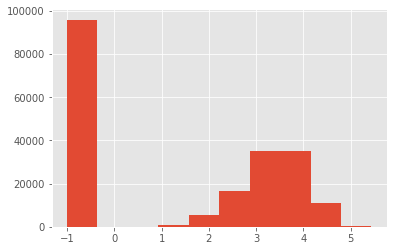

In [44]:
test_request['rating'].hist()